# Differential methylation in EB day 6

## initialize definitions

In [1]:
suppressMessages(suppressWarnings(source(here::here("code/init.R"))))

## Extract data

In [2]:
df <- {
    df_wt <- tracks_key  %>% filter(day == "d6") %>% filter(line == "wt")
    df_ko3a <- tracks_key  %>% filter(day == "d6") %>% filter(line == "ko3a")
    df_ko3b <- tracks_key  %>% filter(day == "d6") %>% filter(line == "ko3b")
    df_ab_bulk <- extract_meth_annot(c(
        df_wt$track_name, 
        df_ko3a$track_name, 
        df_ko3b$track_name,  
        "Zhang_Nature_Genetics_2017.Ect_mCG",
        "Zhang_Nature_Genetics_2017.Mes_mCG",
        "Zhang_Nature_Genetics_2017.End_mCG"), names = c(df_wt$name, df_ko3a$name, df_ko3b$name, "ecto", "meso", "endo"), d_expand = 250, extract_meth_calls = TRUE)
    df <- df_ab_bulk %>% select(chrom, start, end, d_exon:gc_cont, ecto, ecto.cov, meso, meso.cov, endo, endo.cov)
    df$wt.meth <- rowSums(df_ab_bulk[, paste0(df_wt$name, ".meth")], na.rm=TRUE)
    df$wt.cov <- rowSums(df_ab_bulk[, paste0(df_wt$name, ".cov")], na.rm=TRUE)

    df$ko3a.meth <- rowSums(df_ab_bulk[, paste0(df_ko3a$name, ".meth")], na.rm=TRUE)
    df$ko3a.cov <- rowSums(df_ab_bulk[, paste0(df_ko3a$name, ".cov")], na.rm=TRUE)

    df$ko3b.meth <- rowSums(df_ab_bulk[, paste0(df_ko3b$name, ".meth")], na.rm=TRUE)
    df$ko3b.cov <- rowSums(df_ab_bulk[, paste0(df_ko3b$name, ".cov")], na.rm=TRUE)

    df$ko3a <- df$ko3a.meth / df$ko3a.cov
    df$wt <- df$wt.meth / df$wt.cov
    df$ko3b <- df$ko3b.meth / df$ko3b.cov
    df    
} %cache_df% here("output/ab_diff_d6_bulk.tsv") %>% as_tibble()

We take only regions that are well covered and add a `diff` column with `3a(-/-) - 3b(-/-)`

In [3]:
min_cov <- 50
df_diff <- {
        df_diff <- df %>% filter(ko3a.cov >= min_cov, ko3b.cov >= min_cov, wt.cov >= min_cov) %>% mutate(diff = ko3a - ko3b)
        df_diff <- df_diff %>% gintervals.neighbors1("intervs.global.tss") %>% select(chrom:diff, geneSymbol, dist)
        df_diff
} %cache_df%  here("output/ab_diff_d6_bulk_diff.tsv") %>% as_tibble()

In [4]:
dim(df_diff)

[1] 9130435      29

## Plot global differences

In [5]:
sqrt(min_cov)/min_cov

[1] 0.1414214

### Figure 7D

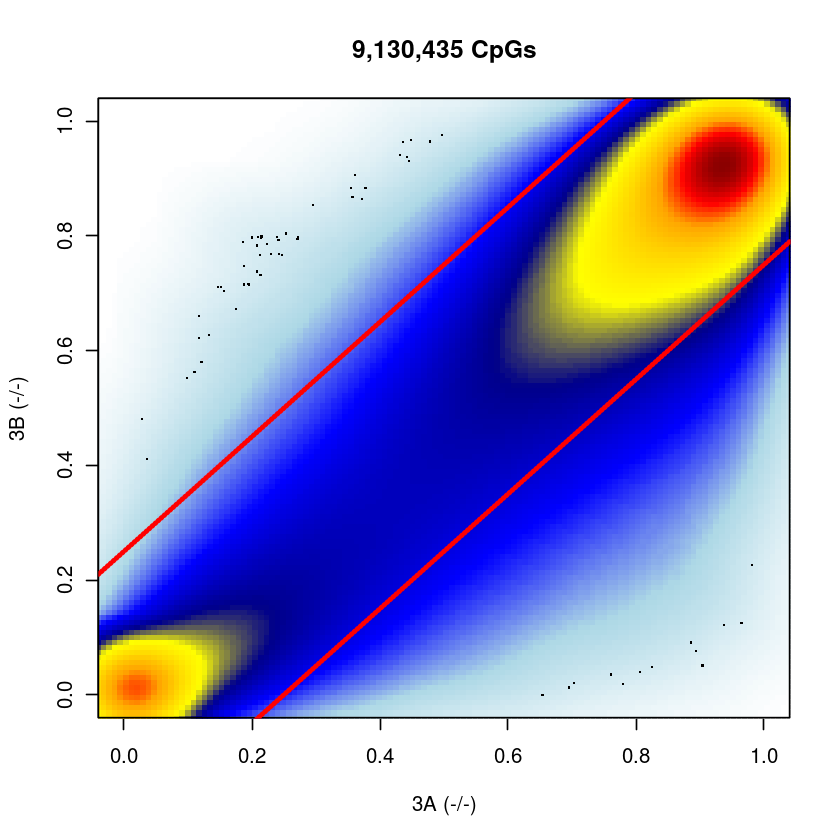

In [6]:
options(repr.plot.width = 7, repr.plot.height = 7)
shades <- colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" ))    
smoothScatter(df_diff$ko3a, df_diff$ko3b, colramp = shades, xlab = "3A (-/-)", ylab = "3B (-/-)")
abline(a = 0.25, b = 1, lty = 3, lwd = 3, col="red")
abline(a = -0.25, b = 1, lty = 3, lwd = 3, col="red")
title(glue("{scales::comma(nrow(df_diff))} CpGs"))

Focusing only on promoters: 

In [7]:
df_diff_prom <- df_diff %>%
        gintervals.neighbors1(get_promoters()) %>%
        filter(dist1 == 0) %>%
        select(-(chrom1:dist1)) %cache_df%  here("output/ab_diff_d6_bulk_diff_promoters.tsv") %>% as_tibble()

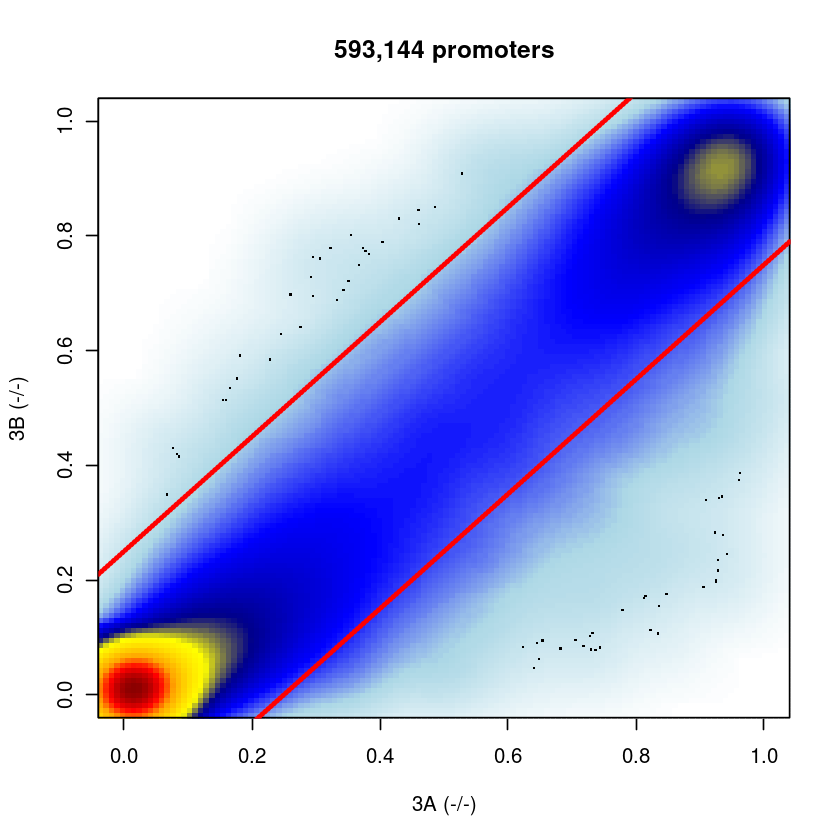

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7)
shades <- colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" ))    
smoothScatter(df_diff_prom$ko3a, df_diff_prom$ko3b, colramp = shades, xlab = "3A (-/-)", ylab = "3B (-/-)")
abline(a = 0.25, b = 1, lty = 3, lwd = 3, col="red")
abline(a = -0.25, b = 1, lty = 3, lwd = 3, col="red")
title(glue("{scales::comma(nrow(df_diff_prom))} promoters"))

In [9]:
df_diff_prom %>%
        filter(diff <= -0.3) %>% 
        nrow()

[1] 169

## Extract DNMT3A targets

We extract regions with differences that are below `-0.3` (places where `3a(-/-) - 3b(-/-) <= -0.3` (upper left part of the scatter).
These are places where `3a(-/-)` is less methylated, i.e. putative targets of DNMT3A.

In [10]:
regs <- df_diff %>% 
    filter(diff <= -0.3) %>% 
    mutate(start = start - 250, end = end + 250) %>% 
    gintervals.canonic() %>% 
    gextract(c("d_exon", "d_tss", "tor", "ab_score", "cg_cont", "gc_cont"), intervals=., iterator=.) %>% 
    gintervals.neighbors1("intervs.global.tss") %>% 
    select(chrom:gc_cont, geneSymbol, dist) %cache_df% 
    here("output/ab_eb_d6_ko3b_hyper.tsv") %>% 
    as_tibble()

In [11]:
dim(regs)

[1] 1525   11

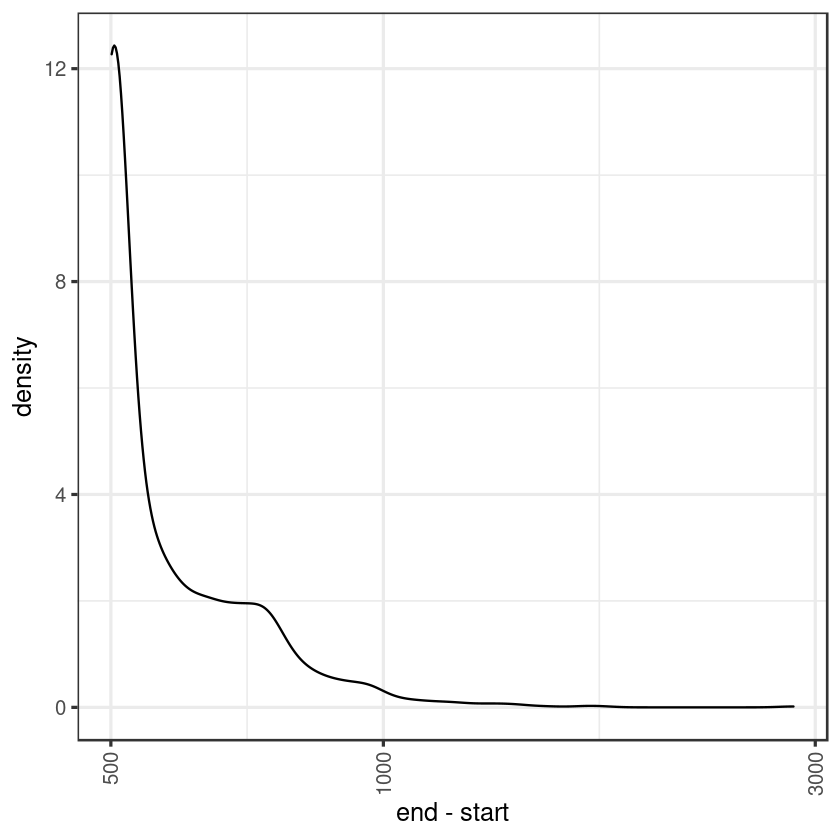

In [12]:
regs %>% ggplot(aes(x=end - start)) + geom_density() + scale_x_log10()


In [13]:
sup_table <- {
    df_wt <- tracks_key  %>% filter(day == "d6") %>% filter(line == "wt")
    df_ko3a <- tracks_key  %>% filter(day == "d6") %>% filter(line == "ko3a")
    df_ko3b <- tracks_key  %>% filter(day == "d6") %>% filter(line == "ko3b")
    df_ab_bulk <- extract_meth_annot(c(
        df_wt$track_name, 
        df_ko3a$track_name, 
        df_ko3b$track_name,  
        "Zhang_Nature_Genetics_2017.Ect_mCG",
        "Zhang_Nature_Genetics_2017.Mes_mCG",
        "Zhang_Nature_Genetics_2017.End_mCG"), names = c(df_wt$name, df_ko3a$name, df_ko3b$name, "ecto", "meso", "endo"), d_expand = 250, extract_meth_calls = TRUE, intervals = regs, iterator=regs)
    df <- df_ab_bulk %>% select(chrom, start, end, d_exon:gc_cont, ecto, ecto.cov, meso, meso.cov, endo, endo.cov)
    df$wt.meth <- rowSums(df_ab_bulk[, paste0(df_wt$name, ".meth")], na.rm=TRUE)
    df$wt.cov <- rowSums(df_ab_bulk[, paste0(df_wt$name, ".cov")], na.rm=TRUE)

    df$ko3a.meth <- rowSums(df_ab_bulk[, paste0(df_ko3a$name, ".meth")], na.rm=TRUE)
    df$ko3a.cov <- rowSums(df_ab_bulk[, paste0(df_ko3a$name, ".cov")], na.rm=TRUE)

    df$ko3b.meth <- rowSums(df_ab_bulk[, paste0(df_ko3b$name, ".meth")], na.rm=TRUE)
    df$ko3b.cov <- rowSums(df_ab_bulk[, paste0(df_ko3b$name, ".cov")], na.rm=TRUE)

    df$ko3a <- df$ko3a.meth / df$ko3a.cov
    df$wt <- df$wt.meth / df$wt.cov
    df$ko3b <- df$ko3b.meth / df$ko3b.cov
    df    
} 
head(sup_table)

chrom,start,end,d_exon,d_tss,tor,ab_score,a_score,b_score,cg_cont,⋯,endo.cov,wt.meth,wt.cov,ko3a.meth,ko3a.cov,ko3b.meth,ko3b.cov,ko3a,wt,ko3b
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,12856026,12856579,328,23572,1.3366647,-0.4332772,-0.4043494,0.04263026,0.01212121,⋯,163,355,450,69,130,72,98,0.5307692,0.7888889,0.7346939
chr1,13117554,13118055,-560,-560,0.6330189,-0.4057871,-0.3534880,0.04959648,0.02231405,⋯,346,474,1109,82,288,123,304,0.2847222,0.4274121,0.4046053
chr1,13524846,13525376,29671,54833,0.8855244,-0.5009643,-0.4720550,0.06331065,0.02303030,⋯,316,702,791,188,246,201,214,0.7642276,0.8874842,0.9392523
chr1,14495784,14496427,-195825,-195825,-0.8437675,-0.4262571,-0.3651721,0.05616216,0.02012987,⋯,349,308,888,61,298,114,320,0.2046980,0.3468468,0.3562500
chr1,14497465,14498563,-197734,-197734,-0.8437675,-0.4453787,-0.3654922,0.06639115,0.01604743,⋯,404,745,1089,108,282,221,359,0.3829787,0.6841139,0.6155989
chr1,14907781,14908427,701,838,-0.9435036,-0.3355332,-0.2938322,0.05721129,0.01545454,⋯,125,343,440,76,138,83,113,0.5507246,0.7795455,0.7345133


In [14]:
sup_table %>% 
    select(chrom:end, ko3a, ko3a.cov, ko3b, ko3b.cov, wt, wt.cov, ab_score, `CG content`=cg_cont, `GC content`=gc_cont) %>% 
    inner_join(regs %>% select(chrom:end, geneSymbol, `distance to gene`=dist)) %>% 
    writexl::write_xlsx(path = here("output/S3 - DNMT3A DMRs.xlsx"))    


Joining, by = c("chrom", "start", "end")


## Plot distribution of AB score on the differential regions

In [15]:
all_intervs <- df_diff %>% mutate(start = start - 250, end = end + 250) %>% select(chrom, start, end) %>% as.data.frame() %>% gintervals.force_range() %>% gintervals.canonic() %>% gextract(c("d_exon", "d_tss", "tor", "ab_score", "cg_cont", "gc_cont"), intervals=., iterator=.)

40%...68%...100%


### Figure 7E

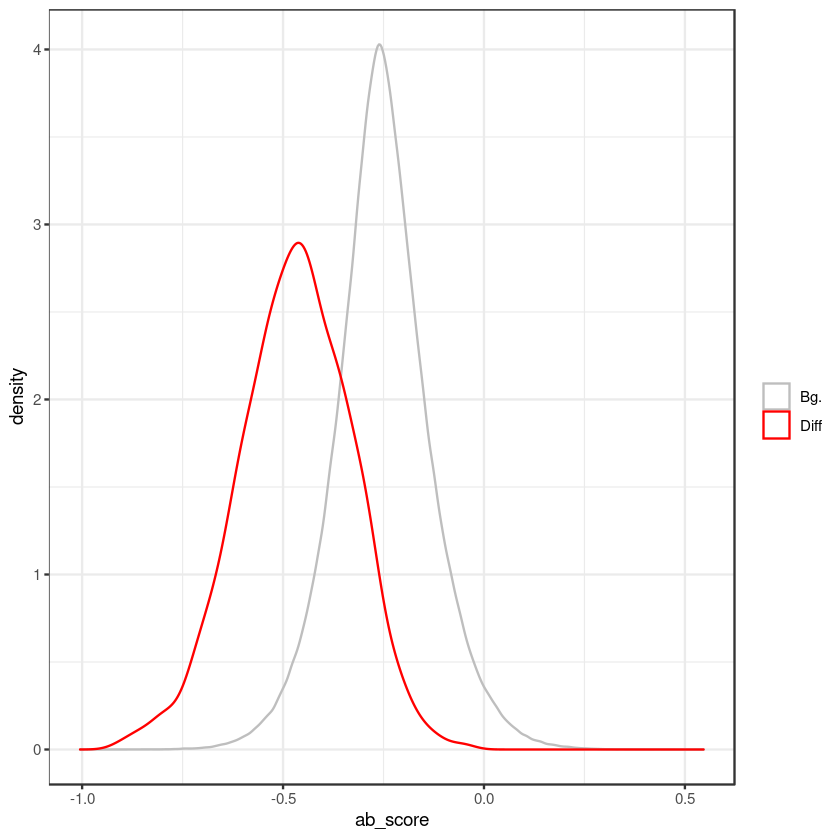

In [16]:
p_ab_score_regs <- bind_rows(all_intervs %>% mutate(type = 'Bg.'), regs %>% mutate(type = 'Diff'))  %>% ggplot(aes(x=ab_score, color=type)) + geom_density() + scale_color_manual(name = '', values = c("Bg." = "gray", "Diff" = "red"))
p_ab_score_regs + theme_bw()

In [17]:
all_intervs_prom <- df_diff_prom %>% mutate(start = start - 250, end = end + 250) %>% select(chrom, start, end) %>% as.data.frame() %>% gintervals.force_range() %>% gintervals.canonic() %>% gextract(c("d_exon", "d_tss", "tor", "ab_score", "cg_cont", "gc_cont"), intervals=., iterator=.)

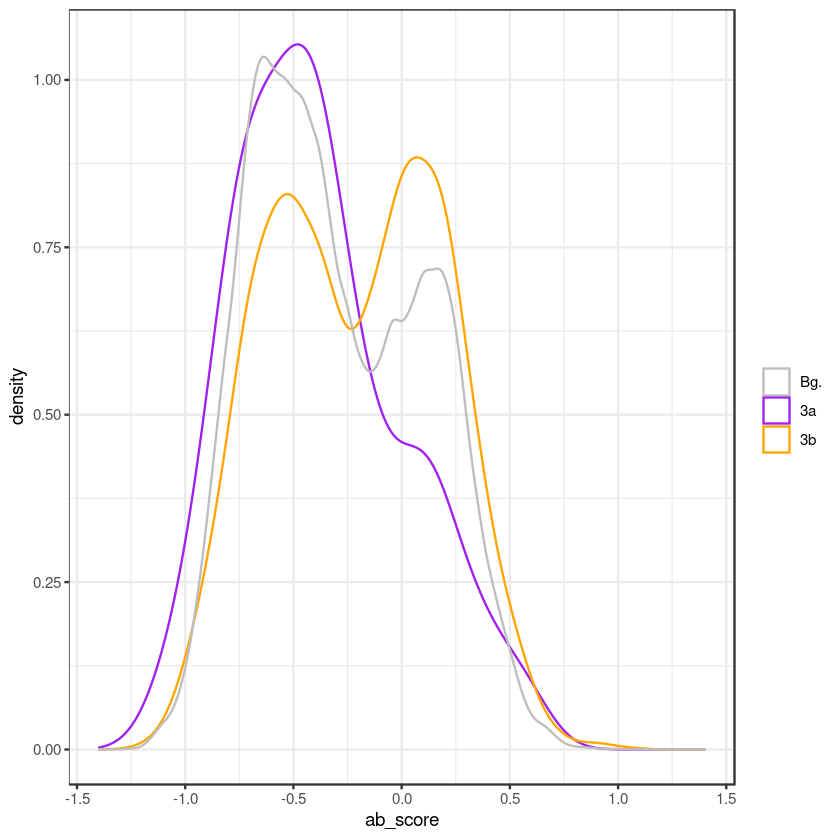

In [18]:
p_ab_score_regs_prom <- df_diff_prom %>%
        mutate(type = case_when(diff <= -0.3 ~ "3a", diff >= 0.3 ~ "3b", TRUE ~ "Bg.")) %>%
        ggplot(aes(x=ab_score, color=type)) + geom_density() + scale_color_manual(name = '', values = c("Bg." = "gray", "3a" = "purple", "3b" = "orange"))
p_ab_score_regs_prom + theme_bw()

## Plot examples 

### Figure 7G, Extended Data Figure 10

[1] "Msx1"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_rect)."
Warning message:
"Removed 14 rows containing missing values (geom_point)."


[1] "Cyp26a1"


Warning message:
"Removed 75 rows containing missing values (geom_point)."


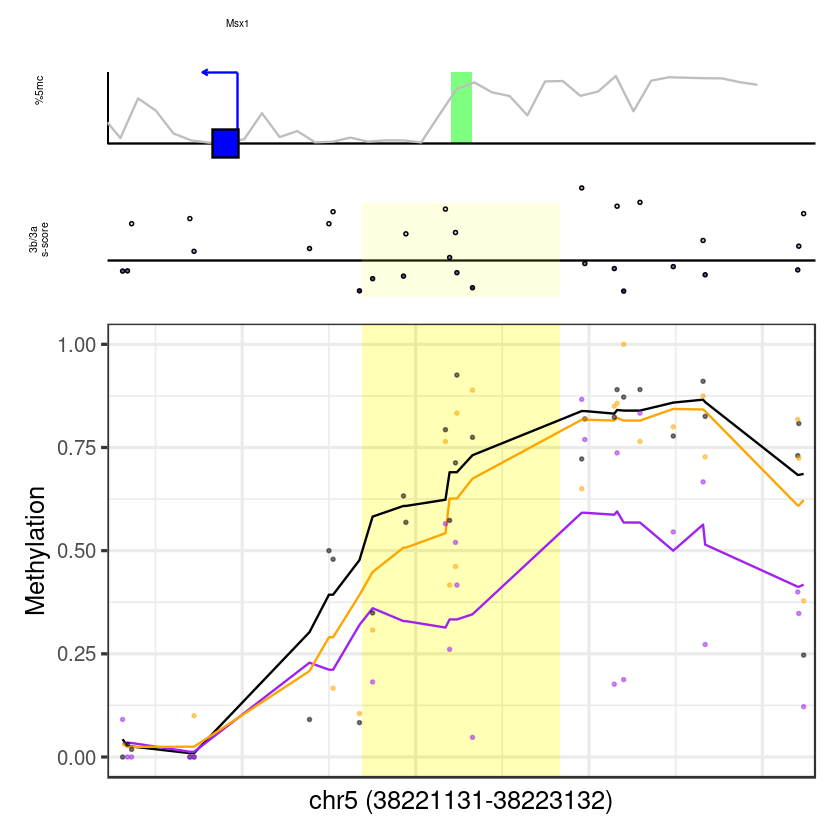

[1] "Foxa2"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 29 rows containing missing values (geom_point)."


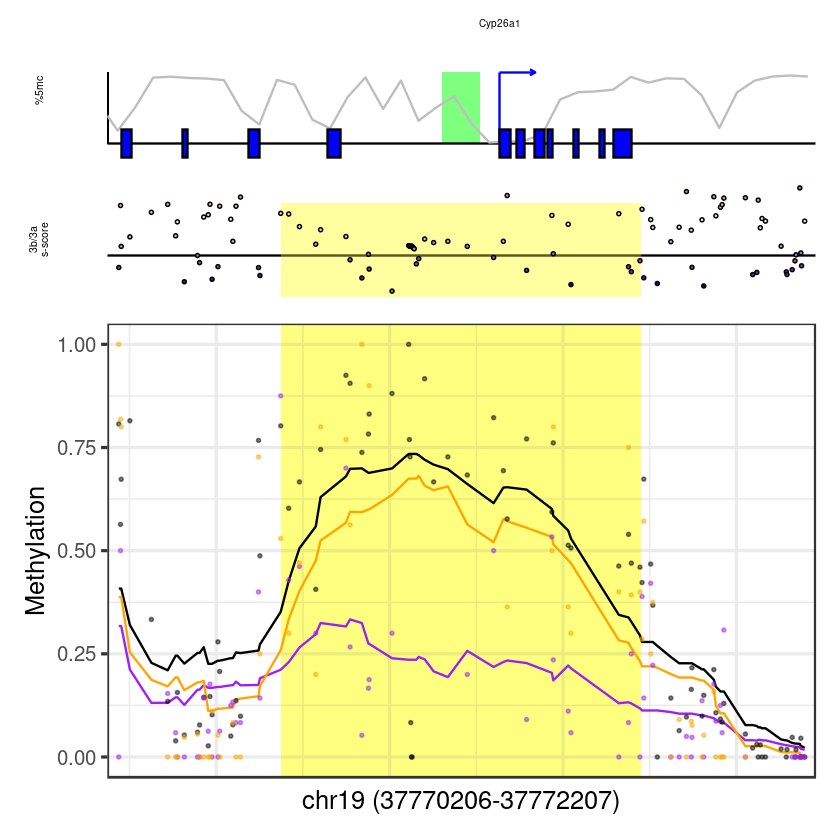

[1] "Krt18"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 9 rows containing missing values (geom_point)."


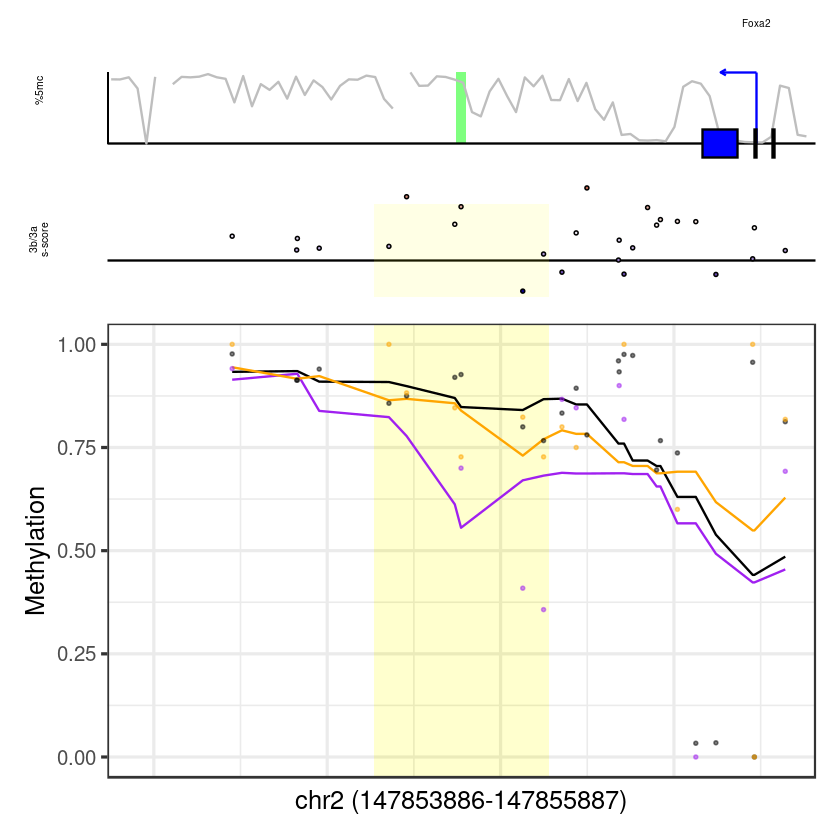

[1] "Sox2"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_rect)."
Warning message:
"Removed 68 rows containing missing values (geom_point)."


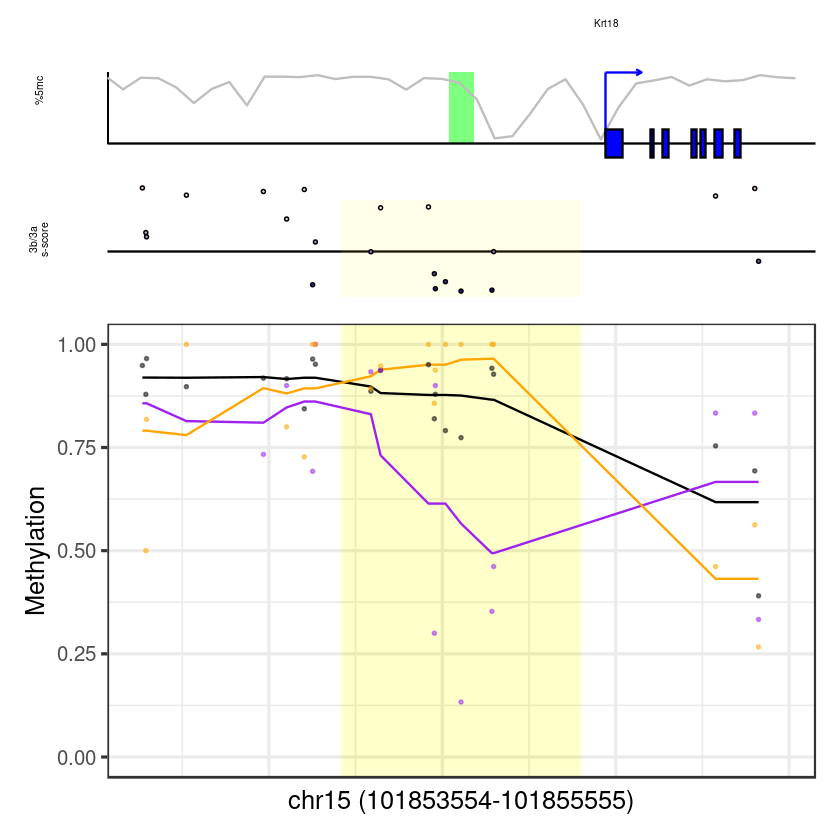

[1] "Sp5"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 15 rows containing missing values (geom_point)."


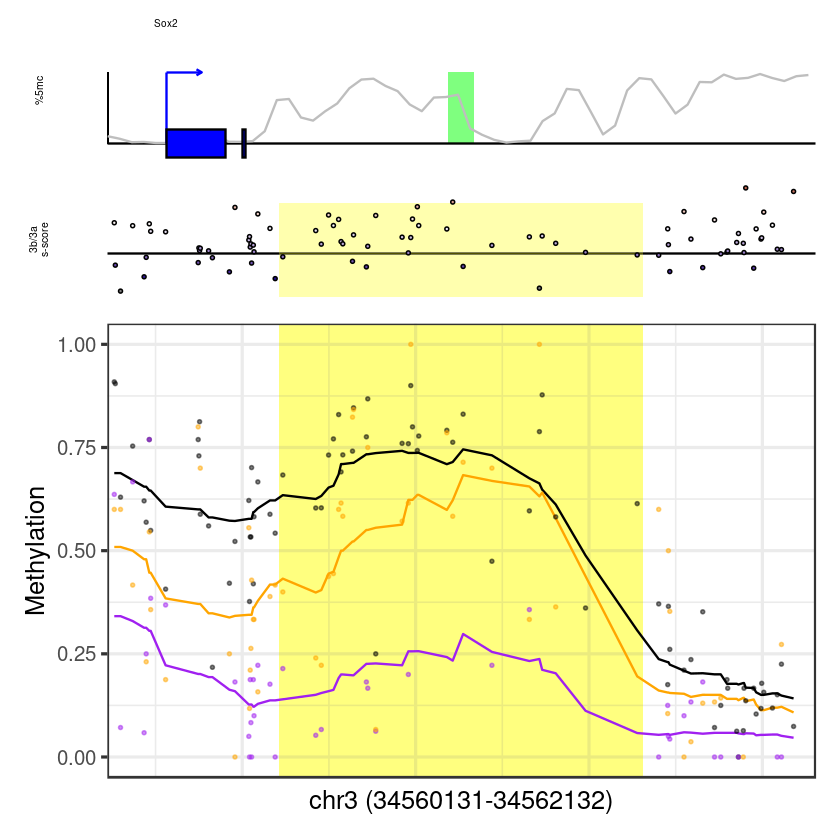

[1] "Zfpm1"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."


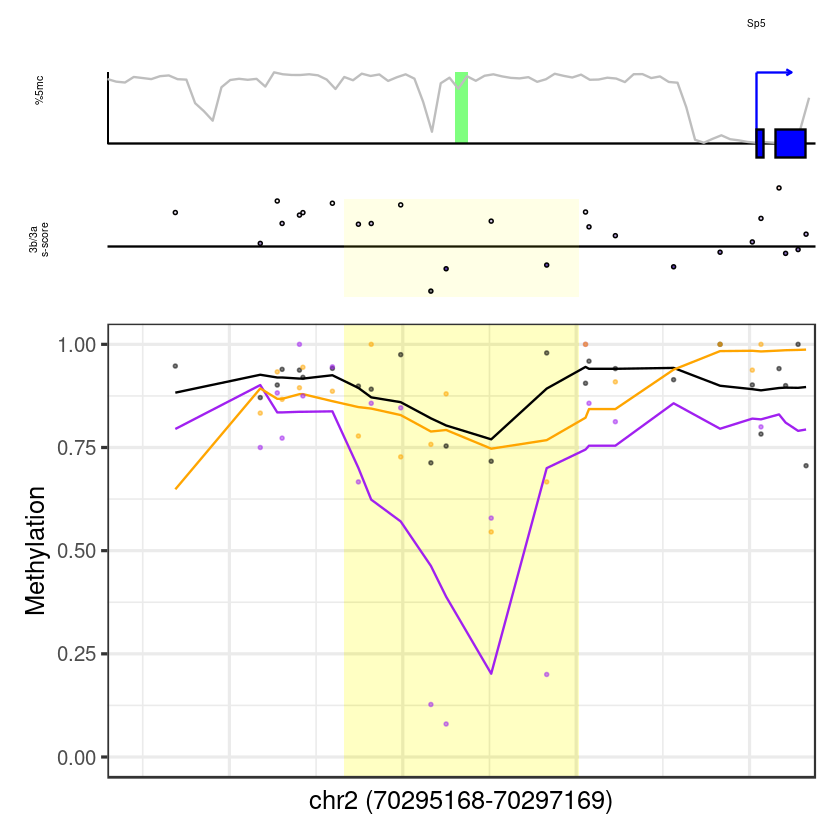

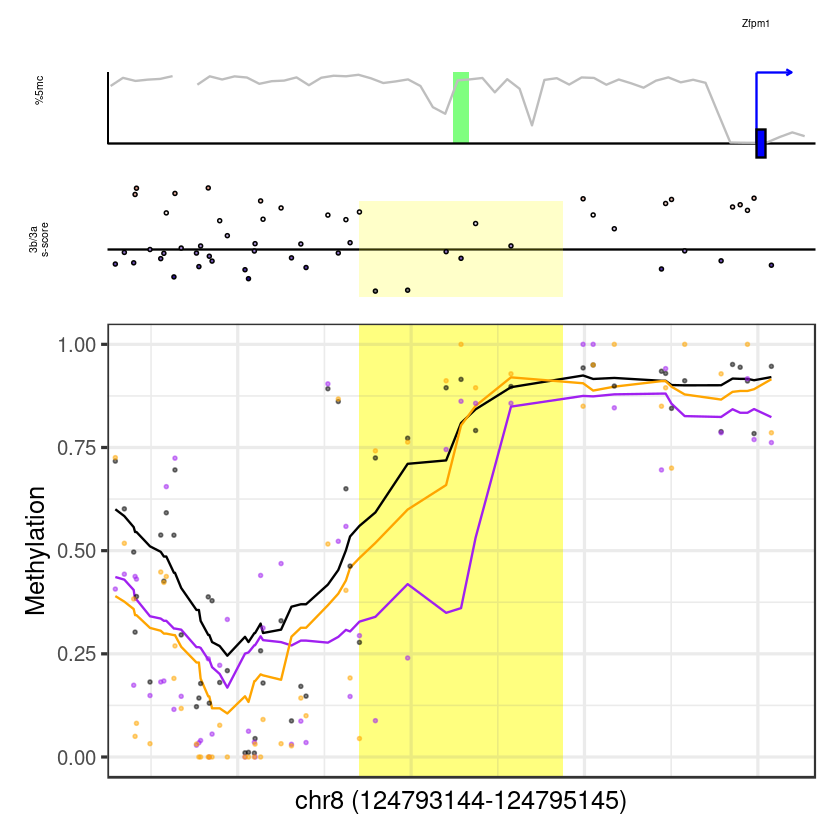

In [22]:
example_genes <- c("Msx1", "Cyp26a1", "Foxa2", "Krt18", "Sox2", "Sp5", "Zfpm1")

plot_example <- function(gene, ...){
    print(gene)
    x <- regs %>% filter(geneSymbol == gene) %>% slice(1)
    genome_res <- max(1e4, abs(x$d_tss) + 0.2 * abs(x$d_tss))
    plot_res <- 1e3
    d_expand <- 250
    med_ab_score = gquantiles("DNMT.ab_score")
    p <- plot_ab_diff_cis_example(x, c("mEBDNMT.comb.d6_wt", "mEBDNMT.comb.d6_ko3a", "mEBDNMT.comb.d6_ko3b"), names = c("wt", "ko3a", "ko3b"), colors =  c("wt" = "black", "ko3a" = "purple", "ko3b" = "orange"),  trend_track = "mEBDNMT.comb.d6_wt", trend_res = 500, genome_res = genome_res, plot_res = plot_res, d_expand = d_expand, add_legend = FALSE, med_ab_score= med_ab_score)
    print(p)
}

walk(example_genes, plot_example)

[1] "Eomes"  "Gsc"    "Pou3f1" "Pou5f1" "Sall4"  "Lyl1"

[1] "Eomes"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 8 rows containing missing values (geom_point)."


[1] "Gsc"


Warning message:
"Removed 2 row(s) containing missing values (geom_path)."
Warning message:
"Removed 20 rows containing missing values (geom_point)."


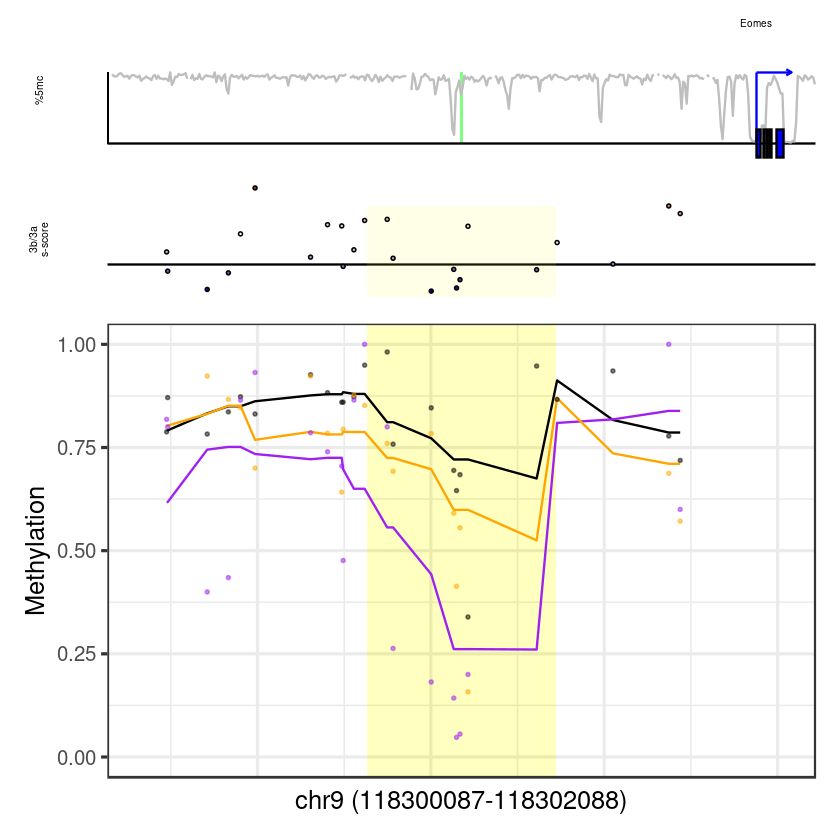

[1] "Pou3f1"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 29 rows containing missing values (geom_point)."


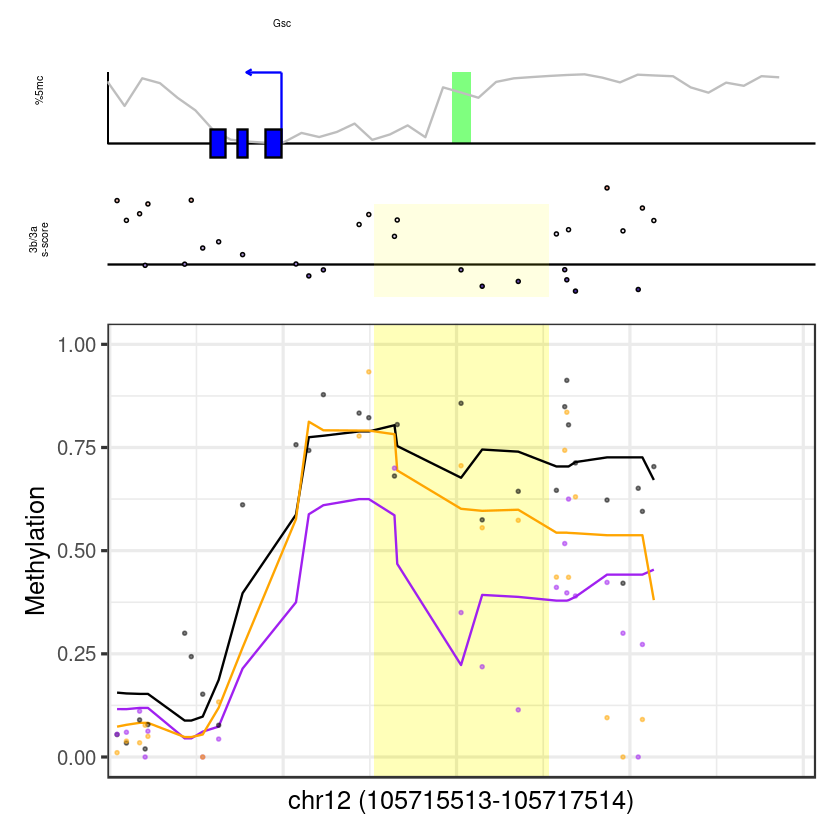

[1] "Pou5f1"


Warning message:
"Removed 2 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_rect)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."


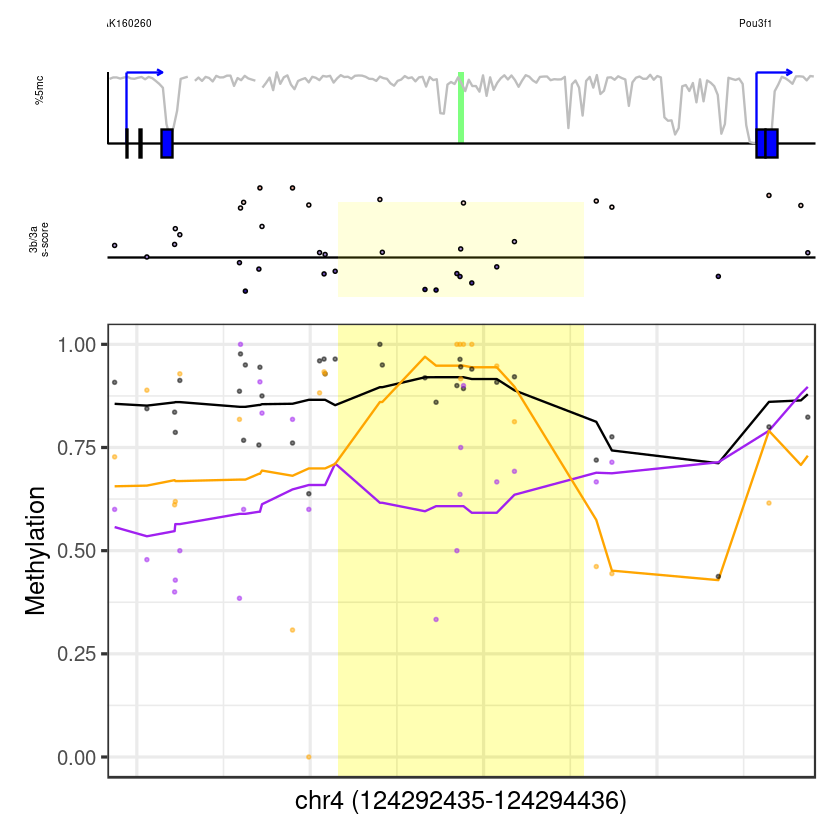

[1] "Sall4"


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message:
"Removed 28 rows containing missing values (geom_point)."


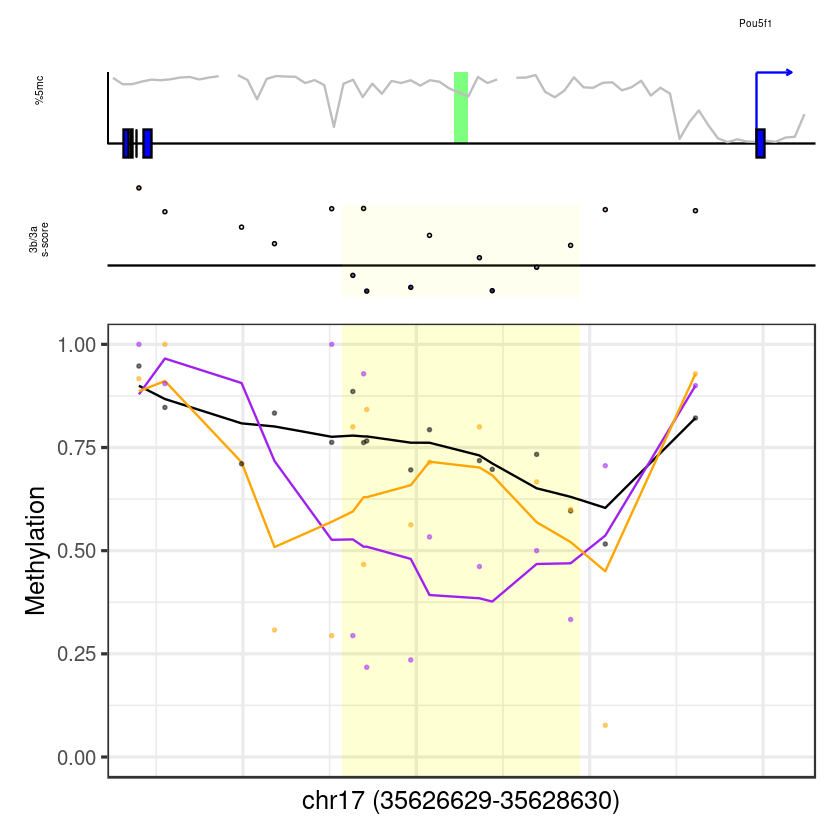

[1] "Lyl1"


Warning message:
"Removed 9 rows containing missing values (geom_point)."


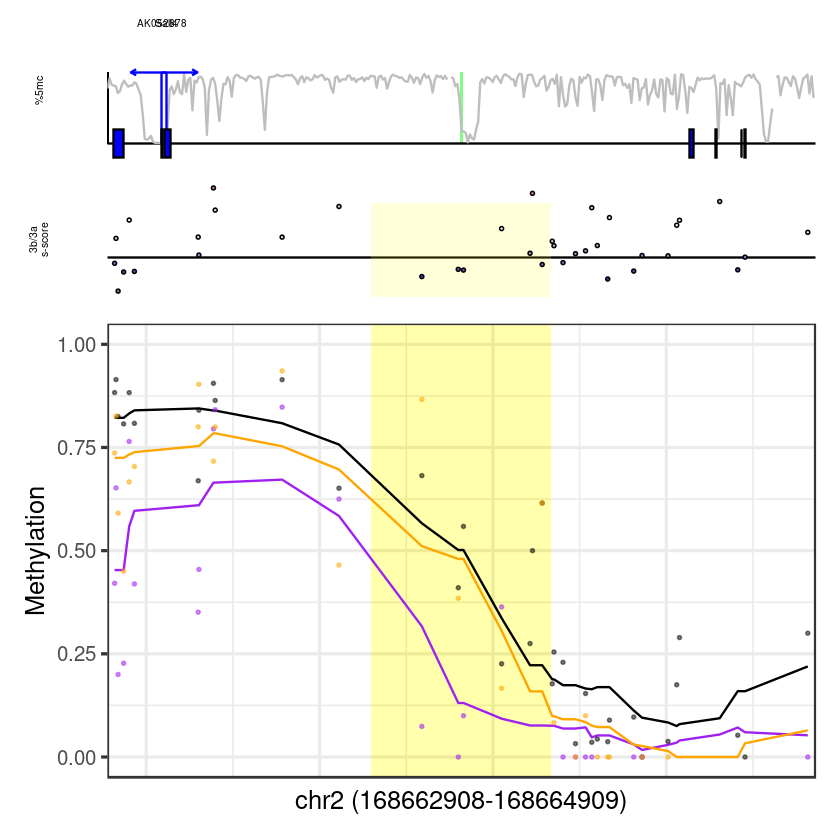

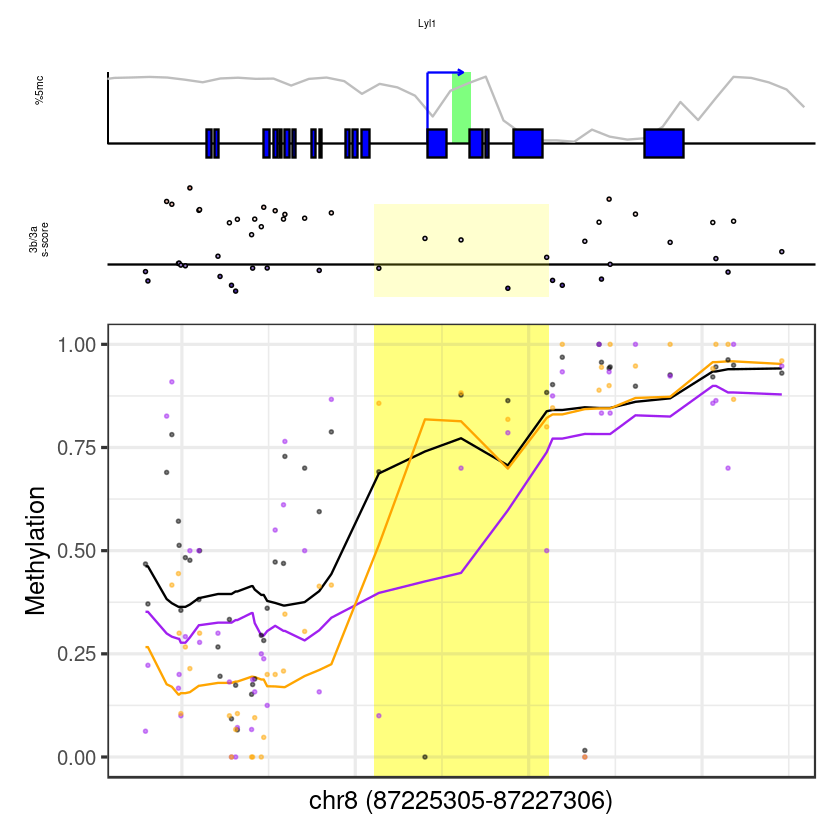

In [23]:
example_cands <- c( "T",
                    "Eomes",
                    "Gsc",                    
                    "Pou3f1",
                    "Pou5f1",
                    "Sall4",                    
                    "Lyl1")

more_examples <- example_cands[example_cands %in% regs$geneSymbol]

more_examples

walk(more_examples, plot_example)

## Test regions enrichment vs gene expression 

In [24]:
germ_genes <- fread_rownames(here("data/germ_genes.txt"), row.var = "geneSymbol") %>% arrange(desc(x) )  %>% slice(1:250) %>% as_tibble()
nrow(germ_genes)

germ_genes <- germ_genes %>% separate_rows(geneSymbol, sep=";") %>% left_join(gintervals.load("intervs.global.tss")) %>% select(chrom, start, end, strand, geneSymbol, x) %>% as_tibble() %>% filter(!is.na(chrom)) %>% distinct(geneSymbol, .keep_all=TRUE)
nrow(germ_genes)

gastru_genes <- fread_rownames(here("data/gastru_genes.txt"), row.var = "geneSymbol") %>% as_tibble()
nrow(gastru_genes)

gastru_genes <- gastru_genes %>% separate_rows(geneSymbol, sep=";") %>% left_join(gintervals.load("intervs.global.tss")) %>% select(chrom, start, end, strand, geneSymbol, x) %>% as_tibble() %>% filter(!is.na(chrom)) %>% distinct(geneSymbol, .keep_all=TRUE)
nrow(gastru_genes)

[1] 250

Joining, by = "geneSymbol"


[1] 267

[1] 1743

Joining, by = "geneSymbol"


[1] 1878

> diff = ko3a - ko3b. 

> diff > 0 => hypo in ko3b => places that 3b methylates.

> diff < 0 => hypo in ko3a => places that 3a methylates.

In [25]:
diff_thresh <- 0.3

regs_3a_intervs <- df_diff  %>% filter(diff >= diff_thresh) %>% mutate(start = start - 250, end = end + 250) %>%
        as.data.frame() %>% 
        gintervals.canonic() %>% 
        mutate(type = "3b")
regs_3b_intervs <- df_diff %>% filter(diff <= -diff_thresh) %>% mutate(start = start - 250, end = end + 250) %>% 
        as.data.frame() %>% 
        gintervals.canonic() %>% 
        mutate(type = "3a")
regs_no_diff_intervs <- df_diff %>% filter(abs(diff) < diff_thresh) %>% mutate(start = start - 250, end = end + 250) %>% 
        as.data.frame() %>% 
        gintervals.force_range() %>% 
        gintervals.canonic() %>% 
        mutate(type = "bg")

22%...40%...63%...86%...100%


In [26]:
df_germ <- bind_rows(regs_3a_intervs, regs_3b_intervs, regs_no_diff_intervs) %>% select(chrom, start, end, type) %>%  gintervals.neighbors1(germ_genes)
df_gastru <- bind_rows(regs_3a_intervs, regs_3b_intervs, regs_no_diff_intervs) %>% select(chrom, start, end, type) %>%  gintervals.neighbors1(germ_genes)

In [27]:
df_germ %>% count(type)

type,n
<chr>,<int>
3a,1525
3b,14404
bg,519255


### Figure 7F

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 335 rows containing non-finite values (stat_ecdf)."


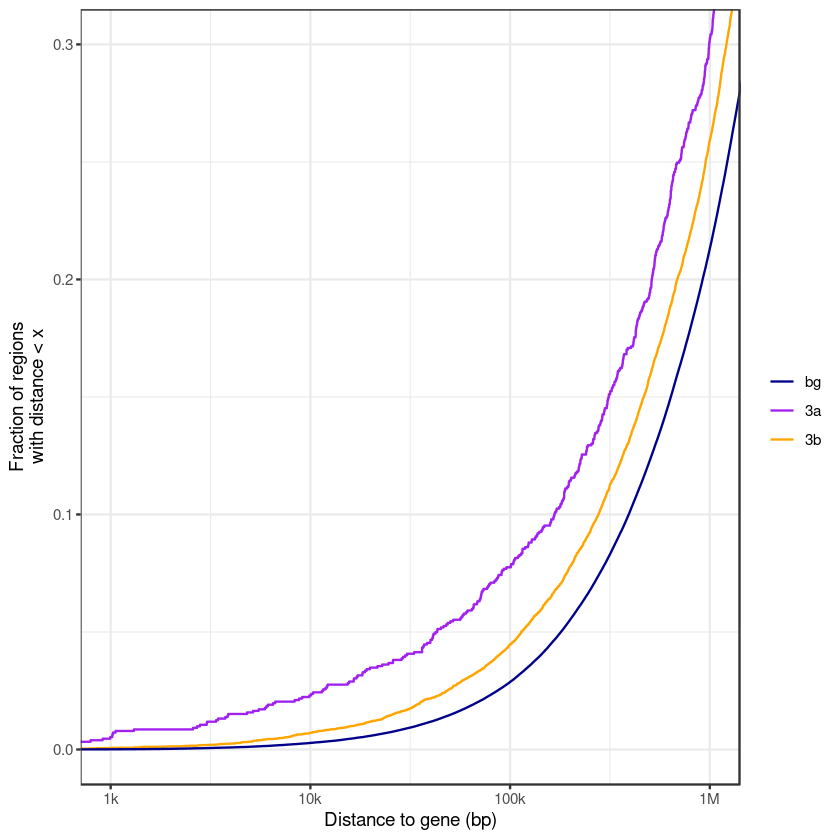

In [28]:
p <- df_germ %>% ggplot(aes(x=abs(dist), color=type)) + stat_ecdf(size=0.5) + scale_color_manual(name = "", values = c("bg" = "darkblue", "3a" = "purple", "3b" = "orange")) + xlab("Distance to gene (bp)") + scale_x_log10(labels = c("0", "1k", "10k", "100k", "1M"), breaks = c(0, 1e3, 1e4, 1e5, 1e6)) + coord_cartesian(xlim = c(1e3,1e6), ylim=c(0,0.3)) + ylab("Fraction of regions\nwith distance < x")
p  + theme_bw() 

In [29]:
ks.test(abs(df_germ$dist[df_germ$type == "3a"]), abs(df_germ$dist[df_germ$type == "3b"]))
ks.test(abs(df_germ$dist[df_germ$type == "3b"]), abs(df_germ$dist[df_germ$type == "bg"]))
ks.test(abs(df_germ$dist[df_germ$type == "3a"]), abs(df_germ$dist[df_germ$type == "bg"]))

Warning message in ks.test(abs(df_germ$dist[df_germ$type == "3a"]), abs(df_germ$dist[df_germ$type == :
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  abs(df_germ$dist[df_germ$type == "3a"]) and abs(df_germ$dist[df_germ$type == "3b"])
D = 0.052219, p-value = 0.001089
alternative hypothesis: two-sided


Warning message in ks.test(abs(df_germ$dist[df_germ$type == "3b"]), abs(df_germ$dist[df_germ$type == :
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  abs(df_germ$dist[df_germ$type == "3b"]) and abs(df_germ$dist[df_germ$type == "bg"])
D = 0.062787, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(abs(df_germ$dist[df_germ$type == "3a"]), abs(df_germ$dist[df_germ$type == :
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  abs(df_germ$dist[df_germ$type == "3a"]) and abs(df_germ$dist[df_germ$type == "bg"])
D = 0.10275, p-value = 2.32e-14
alternative hypothesis: two-sided


Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 335 rows containing non-finite values (stat_ecdf)."


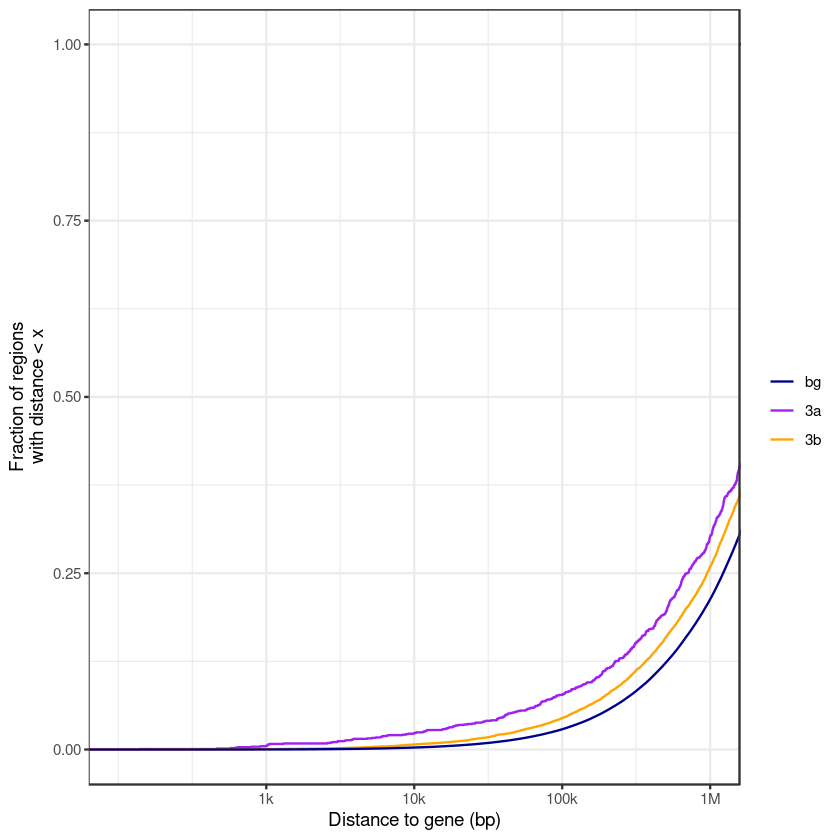

In [30]:
p <- df_gastru %>% ggplot(aes(x=abs(dist), color=type)) + stat_ecdf(size=0.5) + scale_color_manual(name = "", values = c("bg" = "darkblue", "3a" = "purple", "3b" = "orange")) + xlab("Distance to gene (bp)") + scale_x_log10(labels = c("0", "1k", "10k", "100k", "1M"), breaks = c(0, 1e3, 1e4, 1e5, 1e6)) + coord_cartesian(xlim = c(100,1e6)) + ylab("Fraction of regions\nwith distance < x")
p  + theme_bw() 

In [31]:
ks.test(abs(df_gastru$dist[df_gastru$type == "3a"]), abs(df_gastru$dist[df_gastru$type == "3b"]))
ks.test(abs(df_gastru$dist[df_gastru$type == "3b"]), abs(df_gastru$dist[df_gastru$type == "bg"]))
ks.test(abs(df_gastru$dist[df_gastru$type == "3a"]), abs(df_gastru$dist[df_gastru$type == "bg"]))

Warning message in ks.test(abs(df_gastru$dist[df_gastru$type == "3a"]), abs(df_gastru$dist[df_gastru$type == :
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  abs(df_gastru$dist[df_gastru$type == "3a"]) and abs(df_gastru$dist[df_gastru$type == "3b"])
D = 0.052219, p-value = 0.001089
alternative hypothesis: two-sided


Warning message in ks.test(abs(df_gastru$dist[df_gastru$type == "3b"]), abs(df_gastru$dist[df_gastru$type == :
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  abs(df_gastru$dist[df_gastru$type == "3b"]) and abs(df_gastru$dist[df_gastru$type == "bg"])
D = 0.062787, p-value < 2.2e-16
alternative hypothesis: two-sided


Warning message in ks.test(abs(df_gastru$dist[df_gastru$type == "3a"]), abs(df_gastru$dist[df_gastru$type == :
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  abs(df_gastru$dist[df_gastru$type == "3a"]) and abs(df_gastru$dist[df_gastru$type == "bg"])
D = 0.10275, p-value = 2.32e-14
alternative hypothesis: two-sided
